# Gold Stock Price Prediction using CNN-LSTM with PyTorch
This notebook demonstrates EDA, feature engineering, and training a CNN-LSTM model on the gold stock prices dataset.

## 1. Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

## 2. Load and Inspect Data

In [7]:
df = pd.read_csv('/kaggle/input/gold-stock-prices/goldstock v2.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

df.head()


,Unnamed: 0,Close/Last,Volume,Open,High,Low
Date,,,,,,
2014-07-07,2528,1317.0,79110.0,1321.4,1321.7,1312.1
2014-07-08,2527,1316.5,126706.0,1320.8,1325.7,1314.3
2014-07-09,2526,1324.3,155101.0,1320.4,1333.4,1318.7
2014-07-10,2525,1339.2,167391.0,1325.0,1346.8,1325.0
2014-07-11,2524,1337.4,88470.0,1336.5,1340.4,1334.6


## 3. Exploratory Data Analysis (EDA)

In [11]:
df['Close/Last'].describe()

count    2511.000000
mean     1541.176902
std       333.631989
min      1049.600000
25%      1251.300000
50%      1409.700000
75%      1832.050000
max      2438.500000
Name: Close/Last, dtype: float64

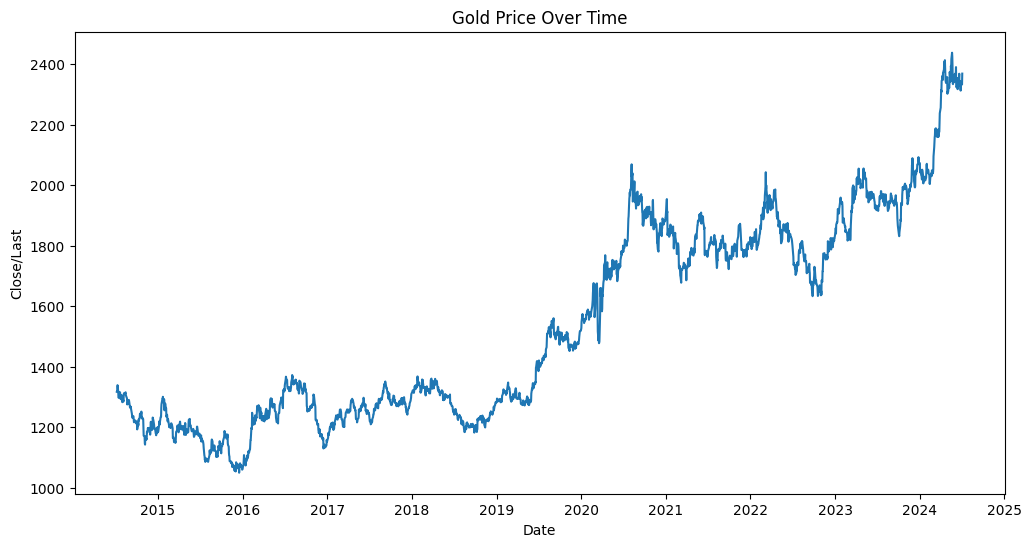

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close/Last'])
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close/Last')
plt.show()

## 4. Feature Engineering

In [15]:
df['MA10'] = df['Close/Last'].rolling(window=10).mean()
df['MA20'] = df['Close/Last'].rolling(window=20).mean()
df = df.dropna()
df.head()

,Unnamed: 0,Close/Last,Volume,Open,High,Low,MA10,MA20
Date,,,,,,,,
2014-08-01,2509,1294.8,130480.0,1284.2,1298.4,1281.0,1300.88,1308.655
2014-08-04,2508,1288.9,62664.0,1295.4,1296.4,1287.0,1298.22,1307.250
2014-08-05,2507,1285.3,95648.0,1289.2,1295.0,1283.3,1295.95,1305.690
2014-08-06,2506,1308.2,147308.0,1288.9,1311.0,1288.5,1296.12,1304.885
2014-08-07,2505,1312.5,117073.0,1306.6,1316.4,1303.0,1298.10,1303.550


## 5. Data Preprocessing

In [17]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

feature_data = df[['Close/Last', 'MA10', 'MA20']].values
target_data = df[['Close/Last']].values

feature_scaled = feature_scaler.fit_transform(feature_data)
target_scaled = target_scaler.fit_transform(target_data)

def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:(i + seq_length)])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

seq_length = 20
X, y = create_sequences(feature_scaled, target_scaled, seq_length)

## 6. Prepare DataLoaders

In [18]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## 7. Build CNN-LSTM Model

In [19]:
class CNNLSTM(nn.Module):
    def __init__(self, n_features, seq_length, n_hidden, n_layers=1):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=64 * seq_length, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(n_hidden, 1)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1).unsqueeze(1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc(x)

n_features = X_train.shape[2]
model = CNNLSTM(n_features=n_features, seq_length=seq_length, n_hidden=50)

## 8. Train the Model

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.6f}')

Epoch 10/50, Loss: 0.000312
Epoch 20/50, Loss: 0.000182
Epoch 30/50, Loss: 0.000153
Epoch 40/50, Loss: 0.000162
Epoch 50/50, Loss: 0.000168


## 9. Evaluate the Model

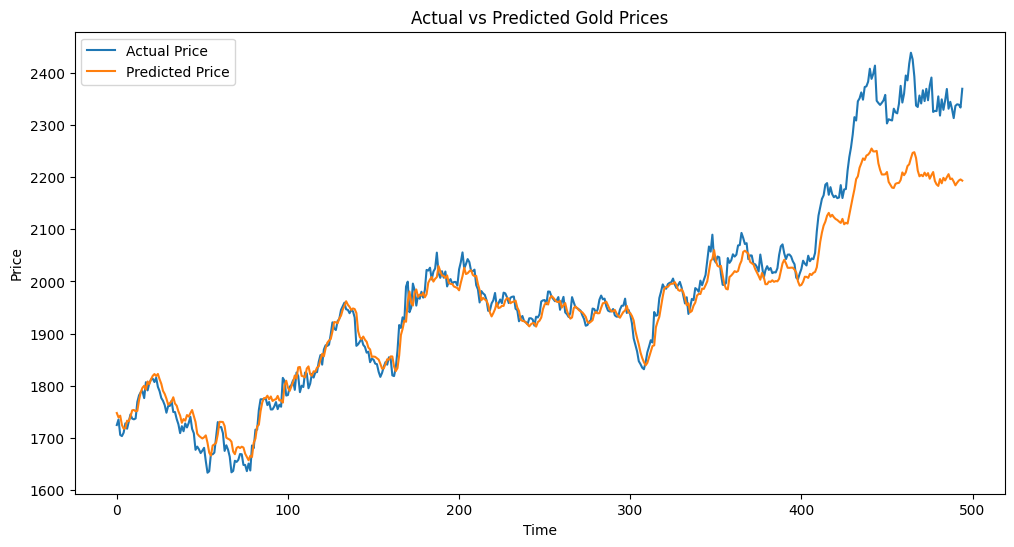

Test MSE on original scale: 3349.7373


In [21]:
model.eval()
preds = []
true_vals = []
with torch.no_grad():
    for xb, yb in test_loader:
        output = model(xb)
        preds.extend(output.numpy())
        true_vals.extend(yb.numpy())

preds = target_scaler.inverse_transform(preds)
true_vals = target_scaler.inverse_transform(true_vals)

plt.figure(figsize=(12,6))
plt.plot(true_vals, label='Actual Price')
plt.plot(preds, label='Predicted Price')
plt.title('Actual vs Predicted Gold Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

test_loss = np.mean((preds - true_vals)**2)
print(f'Test MSE on original scale: {test_loss:.4f}')

## 10. Conclusions
The CNN-LSTM model demonstrates the capacity to learn complex temporal patterns in gold price series. Further improvements could include hyperparameter tuning, additional technical indicators, or alternative model architectures.